# Exploring cities around Europe 

## 1. Introduction

### 1.1 Description 

As everybody else, at some point, I started thinking about cities where I would enjoy living in. In my case, those thoughts came to my mind after I finished my Computer Engineering studies in Alicante (a beautiful and sunny city in the south-east of Spain). Thanks to the many posibilities for exchanges and internships that the University of Alicante gave me, I have gained some ideas about what is important to think about when you are planning about moving to a new city. 

In this project, we will take into account only countries in the European Union. The EU is a unique economic and political union between 28 EU countries that together cover much of the continent. It was created in 1958 and since then It has eliminated borders between the belonged countries, facilitating live, work and travelling abroad in Europe. Also, It created the Euro, a single currency which it mission is to stabilize the economy and help to get equality between the countries. 

But, of course, all these cities are very different between them, total population, culture, yearly sunny hours, language, average salary and working hours are some of the factors that completely change how is to live in a city. We will cluster by how similar they are in comparison to each other.

### 1.2 Data descrition

Classify a city can be very complicated and forces to get a lot of data from different sources:

- We will get the cities with it population and countries from wikipedia: 
https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits

- From Foursquare API, we will extract relevant information about venues of each city.

- Using Meteoblue, we will get the coordinates from each city.

## 2. Data extraction

To start, we will extract all the cities from the wikipedia link in the previous paragraph.

First, we import all the needed libraries and download the data of the link:

In [1]:
from requests import get
import pandas as pd
from bs4 import BeautifulSoup
from pandas.io.json import json_normalize
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

Parser the html, structure and clean the data to extract name of the city, country and population:

In [2]:
url = 'https://en.wikipedia.org/wiki/List_of_cities_in_the_European_Union_by_population_within_city_limits'
response = get(url)
html_soup = BeautifulSoup(response.text, 'html.parser')
table = html_soup.find('table', {'class': 'wikitable sortable'})
table_rows = table.find_all('tr')
table_columns = table.find_all('th')

c = []
for th in table_columns:
    text = th.text.replace('\n', '')
    c.append(text)
c = c[0:3]

r = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text for tr in td]
    
    #Handle if there is an empty row, if not, exception will be thrown
    if(row == []):
        continue
        
    #format data correctly
    row[0] = row[0].split('[')[0]
    row[1] = row[1].strip('\xa0').strip('\n')
    row[2] = row[2].split('♠')[1].strip('\n')
    row = row[0:3]
    
    r.append(row)
df = pd.DataFrame(r, columns=c)

#change name of population column.    
df=df.rename(columns = {'Officialpopulation':'Population'})

In [3]:
population = []
for item in df['Population']:
    population.append(int(item.replace(',', '')))
df['Population'] = population

Display the 5 cities in EU with more population:

In [4]:
df.head()

,City,Country,Population
0,London,United Kingdom,8825001
1,Berlin,Germany,3723914
2,Madrid,Spain,3223334
3,Rome,Italy,2863970
4,Paris,France,2140526


Let's see the shape of the dataframe

In [5]:
df.shape

(110, 3)

Extract from meteoblue API the coordinates for each city

In [6]:
locationCities = []
for city in df['City']:
    # There is a problem with Cordoba, there is a bigger city in south america (extract adding country for next version)
    if(city == 'Córdoba'):
        url = 'https://www.meteoblue.com/en/server/search/query3?query={}&itemsPerPage=2'.format(city)
        response = get(url).json()
        lon = response['results'][1].get('lon')
        lat = response['results'][1].get('lat')
        print('The coordinates of {} are {}, {}'.format(city, lat, lon))
        locationCities.append([city, lat, lon])
        continue
    url = 'https://www.meteoblue.com/en/server/search/query3?query={}&itemsPerPage=1'.format(city)
    response = get(url).json()
    lon = response['results'][0].get('lon')
    lat = response['results'][0].get('lat')
    print('The coordinates of {} are {}, {}'.format(city, lat, lon))
    locationCities.append([city, lat, lon])
locationCities = pd.DataFrame.from_records(locationCities, columns=['City', 'Latitude', 'Longitude'])
locationCities.head()

The coordinates of London are 51.508499, -0.12574
The coordinates of Berlin are 52.524399, 13.4105
The coordinates of Madrid are 40.4165, -3.70256
The coordinates of Rome are 41.891899, 12.5113
The coordinates of Paris are 48.853401, 2.3488
The coordinates of Bucharest are 44.432301, 26.1063
The coordinates of Vienna are 48.2085, 16.372101
The coordinates of Hamburg are 53.575298, 10.0153
The coordinates of Warsaw are 52.229801, 21.011801
The coordinates of Budapest are 47.498001, 19.0399
The coordinates of Barcelona are 41.388802, 2.15899
The coordinates of Munich are 48.137402, 11.5755
The coordinates of Milan are 45.464298, 9.18951
The coordinates of Prague are 50.088001, 14.4208
The coordinates of Sofia are 42.697498, 23.3242
The coordinates of Brussels are 50.850399, 4.34878
The coordinates of Birmingham are 52.4814, -1.89983
The coordinates of Cologne are 50.9333, 6.95
The coordinates of Naples are 40.8522, 14.2681
The coordinates of Stockholm are 59.3326, 18.064899
The coordinat

,City,Latitude,Longitude
0,London,51.508499,-0.12574
1,Berlin,52.524399,13.41050
2,Madrid,40.416500,-3.70256
3,Rome,41.891899,12.51130
4,Paris,48.853401,2.34880


Now, we will merge the coordinates with the dataframe and transform population string into integer

In [7]:
df = pd.merge(df, locationCities, on=['City'], how='inner')

Let's display the firsts rows

In [8]:
df[:5]

,City,Country,Population,Latitude,Longitude
0,London,United Kingdom,8825001,51.508499,-0.12574
1,Berlin,Germany,3723914,52.524399,13.41050
2,Madrid,Spain,3223334,40.416500,-3.70256
3,Rome,Italy,2863970,41.891899,12.51130
4,Paris,France,2140526,48.853401,2.34880


In this point of the process, we can display the map with the different cities around Europe:

In [9]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  42.14 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  35.88 MB/s
vincent-0.4.4- 100% |################################| Time: 0:00:00  39.13 MB/s
folium-0.5.0-p 100% |################################| Time: 0:00:00  48.25 MB/s


In [28]:
lat_europe = 50.52596
long_europe = 15.25512

map_europe = folium.Map(location=[lat_europe, long_europe], zoom_start=4)
cities=df
# add markers to map
for lat, lng, city, population in zip(df['Latitude'], df['Longitude'], df['City'], df['Population']):
    label = '{}\n{}'.format(city, population)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_europe)  
    
map_europe

To continue, let's connect with the Foursquare API and download all the data for the different cities

In [12]:
CLIENT_ID = '5IQXGYRYYHEY30DJ4RZQR3QQZIVVMOWUADQN4OHLFS0GJ00V' # your Foursquare ID
CLIENT_SECRET = 'UUE4HG0QTUKHRGQGXXFKRM1SOXQDXVA4S2E0WXYMSSFN3DYR' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + '5IQXGYRYYHEY30DJ4RZQR3QQZIVVMOWUADQN4OHLFS0GJ00V')
print('CLIENT_SECRET:' + 'UUE4HG0QTUKHRGQGXXFKRM1SOXQDXVA4S2E0WXYMSSFN3DYR')

Your credentails:
CLIENT_ID: 5IQXGYRYYHEY30DJ4RZQR3QQZIVVMOWUADQN4OHLFS0GJ00V
CLIENT_SECRET:UUE4HG0QTUKHRGQGXXFKRM1SOXQDXVA4S2E0WXYMSSFN3DYR


Test extracting main venues from the first city, in this case will be London

In [13]:
city_latitude = df.loc[0, 'Latitude'] # neighbourhood latitude value
city_longitude = df.loc[0, 'Longitude'] # neighbourhood longitude value

city_name = df.loc[0, 'City'] # neighbourhood name

print('Latitude and longitude values of {} are {}, {}.'.format(city_name, 
                                                               city_latitude, 
                                                               city_longitude))

LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 10000 # define radius

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    city_latitude, 
    city_longitude, 
    radius, 
    LIMIT)
url # display URL

Latitude and longitude values of London are 51.508499, -0.12574.


'https://api.foursquare.com/v2/venues/explore?&client_id=5IQXGYRYYHEY30DJ4RZQR3QQZIVVMOWUADQN4OHLFS0GJ00V&client_secret=UUE4HG0QTUKHRGQGXXFKRM1SOXQDXVA4S2E0WXYMSSFN3DYR&v=20180605&ll=51.508499,-0.12574&radius=10000&limit=100'

In [14]:
results = get(url).json()
results

{'meta': {'code': 200, 'requestId': '5c7cec4c9fb6b7415b387b9b'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4ac518cdf964a520e6a520e3-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/museum_art_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d18f941735',
         'name': 'Art Museum',
         'pluralName': 'Art Museums',
         'primary': True,
         'shortName': 'Art Museum'}],
       'id': '4ac518cdf964a520e6a520e3',
       'location': {'address': 'Trafalgar Sq',
        'cc': 'GB',
        'city': 'London',
        'country': 'United Kingdom',
        'distance': 194,
        'formattedAddress': ['Trafalgar Sq',
         'London',
         'Greater London',
         'WC2N 5DN',
         'United Kingdom'],
        'labeledLatLn

In [15]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [16]:
venues = results['response']['groups'][0]['items']
    
city_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
city_venues =city_venues.loc[:, filtered_columns]

# filter the category for each row
city_venues['venue.categories'] = city_venues.apply(get_category_type, axis=1)

# clean columns
city_venues.columns = [col.split(".")[-1] for col in city_venues.columns]

city_venues.head()

,name,categories,lat,lng
0,National Gallery,Art Museum,51.508876,-0.128478
1,Gordon's Wine Bar,Wine Bar,51.507895,-0.123232
2,Trafalgar Square,Plaza,51.508048,-0.127699
3,Corinthia Hotel,Hotel,51.506607,-0.124460
4,National Portrait Gallery,Art Gallery,51.509438,-0.128032


Define function to get venues for the city

In [17]:
def getCityVenues(names, latitudes, longitudes, radius=10000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [18]:
europe_venues = getCityVenues(names=df['City'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

London
Berlin
Madrid
Rome
Paris
Bucharest
Vienna
Hamburg
Warsaw
Budapest
Barcelona
Munich
Milan
Prague
Sofia
Brussels
Birmingham
Cologne
Naples
Stockholm
Turin
Marseille
Amsterdam
Zagreb
Valencia
Leeds
Copenhagen
Kraków
Frankfurt
Riga
Seville
Łódź
Palermo
Zaragoza
Athens
Rotterdam
Helsinki
Wrocław
Stuttgart
Glasgow
Düsseldorf
Dortmund
Genoa
Essen
Vilnius
Sheffield
Leipzig
Málaga
Gothenburg
Bremen
Dublin
Lisbon
Dresden
Manchester
Poznań
The Hague
Bradford
Hanover
Antwerp
Lyon
Nuremberg
Edinburgh
Duisburg
Liverpool
Toulouse
Gdańsk
Bristol
Tallinn
Murcia
Bratislava
Palma de Mallorca
Szczecin
Bologna
Florence
Brno
Las Palmas
Plovdiv
Bochum
Iași
Cardiff
Bydgoszcz
Coventry
Utrecht
Wuppertal
Leicester
Nice
Bilbao
Lublin
Belfast
Wakefield
Aarhus
Varna
Bielefeld
Timișoara
Malmö
Alicante
Córdoba
Nottingham
Bari
Wigan
Thessaloniki
Bonn
Cluj-Napoca
Constanța
Catania
Münster
Karlsruhe
Craiova
Mannheim
Galați


In [19]:
print(europe_venues.shape)
europe_venues.head()

(10825, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,London,51.508499,-0.12574,National Gallery,51.508876,-0.128478,Art Museum
1,London,51.508499,-0.12574,Gordon's Wine Bar,51.507895,-0.123232,Wine Bar
2,London,51.508499,-0.12574,Trafalgar Square,51.508048,-0.127699,Plaza
3,London,51.508499,-0.12574,Corinthia Hotel,51.506607,-0.124460,Hotel
4,London,51.508499,-0.12574,National Portrait Gallery,51.509438,-0.128032,Art Gallery


In [20]:
print('There are {} uniques categories.'.format(len(europe_venues['Venue Category'].unique())))

There are 402 uniques categories.


10 most common venues in Europe

,Venue Category
Café,643
Hotel,507
Coffee Shop,462
Bar,398
Plaza,364
Park,324
Pub,315
Italian Restaurant,314
Restaurant,298
Ice Cream Shop,233


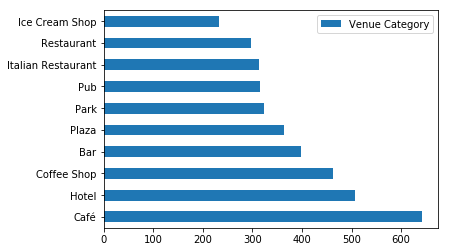

In [22]:
plt_venues_df = europe_venues['Venue Category'].value_counts()[:10].to_frame()
plt_venues_df.plot(kind='barh')
plt_venues_df

Let's analyze each city by the categories of the venues

In [29]:
# one hot encoding
europe_onehot = pd.get_dummies(europe_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
europe_onehot['City'] = europe_venues['City'] 

# move neighborhood column to the first column
fixed_columns = [europe_onehot.columns[-1]] + list(europe_onehot.columns[:-1])
europe_onehot = europe_onehot[fixed_columns]

europe_onehot.head()

,City,Accessories Store,Advertising Agency,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Apple Wine Pub,Aquarium,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,London,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,London,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [30]:
europe_onehot.shape

(10825, 403)

Insert population and normalize

In [31]:
europe_grouped = europe_onehot.groupby('City').mean().reset_index()
europe_grouped.head()

,City,Accessories Store,Advertising Agency,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Apple Wine Pub,Aquarium,...,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,Aarhus,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.03,0.0,0.0,0.0,0.00,0.00,0.0,0.0
1,Alicante,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,...,0.0,0.00,0.01,0.0,0.0,0.0,0.00,0.00,0.0,0.0
2,Amsterdam,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.01,0.00,0.0,0.0,0.0,0.01,0.02,0.0,0.0
3,Antwerp,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.00,0.01,0.0,0.0,0.0,0.02,0.00,0.0,0.0
4,Athens,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.01,0.04,0.0,0.0,0.0,0.00,0.00,0.0,0.0


In [32]:
europe_grouped.shape

(110, 403)

In [27]:
num_top_venues = 5

for city in europe_grouped['City']:
    print("----"+city+"----")
    temp = europe_grouped[europe_grouped['City'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aarhus----
               venue  freq
0               Café  0.12
1        Coffee Shop  0.06
2  French Restaurant  0.06
3               Park  0.05
4                Bar  0.04


----Alicante----
                venue  freq
0    Tapas Restaurant  0.13
1  Spanish Restaurant  0.07
2               Hotel  0.06
3               Plaza  0.06
4         Coffee Shop  0.05


----Amsterdam----
            venue  freq
0           Hotel  0.08
1     Coffee Shop  0.06
2    Cocktail Bar  0.04
3       Bookstore  0.04
4  Sandwich Place  0.04


----Antwerp----
                venue  freq
0         Coffee Shop  0.12
1        Cocktail Bar  0.05
2      Clothing Store  0.05
3      Sandwich Place  0.04
4  Italian Restaurant  0.03


----Athens----
           venue  freq
0  Historic Site  0.09
1           Café  0.08
2    Coffee Shop  0.08
3            Bar  0.06
4   Cocktail Bar  0.06


----Barcelona----
                venue  freq
0               Hotel  0.12
1  Spanish Restaurant  0.09
2    Tapas Restaurant  0.07

         venue  freq
0         Café  0.11
1  Coffee Shop  0.09
2   Steakhouse  0.04
3        Hotel  0.04
4         Park  0.04


----Hanover----
                venue  freq
0         Coffee Shop  0.09
1                Café  0.08
2  Italian Restaurant  0.03
3          Steakhouse  0.03
4               Hotel  0.03


----Helsinki----
                     venue  freq
0              Coffee Shop  0.08
1  Scandinavian Restaurant  0.07
2                     Café  0.04
3                    Hotel  0.04
4   Furniture / Home Store  0.04


----Iași----
                 venue  freq
0                 Café  0.12
1  Romanian Restaurant  0.06
2          Coffee Shop  0.06
3                Hotel  0.04
4   Italian Restaurant  0.03


----Karlsruhe----
                venue  freq
0  Italian Restaurant  0.07
1   German Restaurant  0.06
2                Café  0.05
3           Drugstore  0.04
4         Coffee Shop  0.04


----Kraków----
               venue  freq
0               Café  0.11
1              Hotel  0

          venue  freq
0          Café  0.08
1        Bakery  0.06
2    Restaurant  0.06
3   Coffee Shop  0.05
4  Dessert Shop  0.04


----Toulouse----
               venue  freq
0  French Restaurant  0.21
1                Bar  0.12
2              Plaza  0.08
3             Garden  0.04
4              Hotel  0.04


----Turin----
            venue  freq
0           Plaza  0.11
1  Ice Cream Shop  0.09
2            Café  0.08
3   Historic Site  0.06
4           Hotel  0.06


----Utrecht----
          venue  freq
0   Coffee Shop  0.08
1    Restaurant  0.07
2           Bar  0.07
3  Burger Joint  0.04
4          Park  0.03


----Valencia----
                      venue  freq
0                     Plaza  0.06
1        Italian Restaurant  0.06
2        Spanish Restaurant  0.04
3  Mediterranean Restaurant  0.04
4               Coffee Shop  0.03


----Varna----
          venue  freq
0          Café  0.07
1         Hotel  0.04
2           Bar  0.04
3  Cocktail Bar  0.04
4         Plaza  0.04


----

In [33]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [34]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
cities_venues_sorted = pd.DataFrame(columns=columns)
cities_venues_sorted['City'] = europe_grouped['City']

for ind in np.arange(europe_grouped.shape[0]):
    cities_venues_sorted.iloc[ind, 1:] = return_most_common_venues(europe_grouped.iloc[ind, :], num_top_venues)

cities_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Aarhus,Café,French Restaurant,Coffee Shop,Park,Bakery,Bar,Scandinavian Restaurant,Hotel,Wine Bar,Music Venue
1,Alicante,Tapas Restaurant,Spanish Restaurant,Hotel,Plaza,Coffee Shop,Restaurant,Burger Joint,Ice Cream Shop,Pizza Place,Mediterranean Restaurant
2,Amsterdam,Hotel,Coffee Shop,Sandwich Place,Restaurant,Bookstore,Cocktail Bar,French Restaurant,Organic Grocery,Breakfast Spot,Plaza
3,Antwerp,Coffee Shop,Clothing Store,Cocktail Bar,Sandwich Place,Plaza,Italian Restaurant,Sushi Restaurant,Spanish Restaurant,Bar,Juice Bar
4,Athens,Historic Site,Café,Coffee Shop,Cocktail Bar,Bar,Greek Restaurant,Wine Bar,Meze Restaurant,Hotel,Theater


In [35]:
europe_merged_cluster = df[['City', 'Population']]

europe_merged_cluster = europe_merged_cluster.join(cities_venues_sorted.set_index('City'), on='City')
europe_merged_cluster.head()

,City,Population,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,London,8825001,Hotel,Theater,Steakhouse,Art Museum,Park,Department Store,Bookstore,Bakery,Coffee Shop,Cocktail Bar
1,Berlin,3723914,Coffee Shop,Bookstore,Gourmet Shop,Historic Site,Bakery,Ice Cream Shop,Park,Sandwich Place,Café,Vegetarian / Vegan Restaurant
2,Madrid,3223334,Restaurant,Plaza,Hotel,Tapas Restaurant,Art Gallery,Café,Art Museum,Spanish Restaurant,Bookstore,Cocktail Bar
3,Rome,2863970,Plaza,Historic Site,Ice Cream Shop,Hotel,Monument / Landmark,Sandwich Place,Italian Restaurant,Dessert Shop,Scenic Lookout,Art Museum
4,Paris,2140526,Plaza,Hotel,Cocktail Bar,Italian Restaurant,French Restaurant,Art Museum,Bookstore,Garden,Historic Site,Sandwich Place


Add Population column to the cluster

In [36]:
from sklearn import preprocessing

x = df[['Population']] #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_population_normalized = pd.DataFrame(x_scaled)
df_population_normalized['City'] = df[['City']]

europe_grouped = europe_onehot.groupby('City').mean().reset_index()
europe_grouped = europe_grouped.join(df_population_normalized.set_index('City'), on='City')
europe_grouped = europe_grouped.rename(columns={0:'Population'})
europe_grouped.head()

,City,Accessories Store,Advertising Agency,African Restaurant,Airport,American Restaurant,Amphitheater,Antique Shop,Apple Wine Pub,Aquarium,...,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo,Zoo Exhibit,Population
0,Aarhus,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.00,0.03,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.003679
1,Alicante,0.0,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.0,...,0.00,0.01,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.003010
2,Amsterdam,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.01,0.00,0.0,0.0,0.0,0.01,0.02,0.0,0.0,0.065589
3,Antwerp,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.00,0.01,0.0,0.0,0.0,0.02,0.00,0.0,0.0,0.025539
4,Athens,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.01,0.04,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.041246


# Clustering

In [37]:
# set number of clusters
kclusters = 6

europe_grouped_clustering = europe_grouped.drop('City', 1)

print(europe_grouped_clustering)
# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(europe_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

     Accessories Store  Advertising Agency  African Restaurant  Airport  \
0                 0.00                 0.0                0.00     0.00   
1                 0.00                 0.0                0.00     0.00   
2                 0.00                 0.0                0.00     0.00   
3                 0.00                 0.0                0.00     0.00   
4                 0.00                 0.0                0.00     0.00   
5                 0.00                 0.0                0.00     0.00   
6                 0.00                 0.0                0.00     0.01   
7                 0.00                 0.0                0.00     0.00   
8                 0.00                 0.0                0.00     0.00   
9                 0.00                 0.0                0.00     0.00   
10                0.00                 0.0                0.00     0.00   
11                0.00                 0.0                0.00     0.00   
12                0.00   

array([2, 1, 2, 2, 2, 1, 5, 2, 0, 2], dtype=int32)

In [38]:
# add clustering labels
cities_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

cities_merged = df

cities_merged = cities_merged.join(cities_venues_sorted.set_index('City'), on='City')

cities_merged.head() # check the last columns!

,City,Country,Population,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,London,United Kingdom,8825001,51.508499,-0.12574,4,Hotel,Theater,Steakhouse,Art Museum,Park,Department Store,Bookstore,Bakery,Coffee Shop,Cocktail Bar
1,Berlin,Germany,3723914,52.524399,13.41050,0,Coffee Shop,Bookstore,Gourmet Shop,Historic Site,Bakery,Ice Cream Shop,Park,Sandwich Place,Café,Vegetarian / Vegan Restaurant
2,Madrid,Spain,3223334,40.416500,-3.70256,0,Restaurant,Plaza,Hotel,Tapas Restaurant,Art Gallery,Café,Art Museum,Spanish Restaurant,Bookstore,Cocktail Bar
3,Rome,Italy,2863970,41.891899,12.51130,0,Plaza,Historic Site,Ice Cream Shop,Hotel,Monument / Landmark,Sandwich Place,Italian Restaurant,Dessert Shop,Scenic Lookout,Art Museum
4,Paris,France,2140526,48.853401,2.34880,0,Plaza,Hotel,Cocktail Bar,Italian Restaurant,French Restaurant,Art Museum,Bookstore,Garden,Historic Site,Sandwich Place


In [39]:
# create map
map_clusters = folium.Map(location=[lat_europe, long_europe], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(cities_merged['Latitude'], cities_merged['Longitude'], cities_merged['City'], cities_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine the clusters

In [40]:
cities_merged.loc[cities_merged['Cluster Labels'] == 0, cities_merged.columns[[0] + [1] + [2] + list(range(5, cities_merged.shape[1]))]]

,City,Country,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Berlin,Germany,3723914,0,Coffee Shop,Bookstore,Gourmet Shop,Historic Site,Bakery,Ice Cream Shop,Park,Sandwich Place,Café,Vegetarian / Vegan Restaurant
2,Madrid,Spain,3223334,0,Restaurant,Plaza,Hotel,Tapas Restaurant,Art Gallery,Café,Art Museum,Spanish Restaurant,Bookstore,Cocktail Bar
3,Rome,Italy,2863970,0,Plaza,Historic Site,Ice Cream Shop,Hotel,Monument / Landmark,Sandwich Place,Italian Restaurant,Dessert Shop,Scenic Lookout,Art Museum
4,Paris,France,2140526,0,Plaza,Hotel,Cocktail Bar,Italian Restaurant,French Restaurant,Art Museum,Bookstore,Garden,Historic Site,Sandwich Place
5,Bucharest,Romania,2104967,0,Coffee Shop,Hotel,Tea Room,Dessert Shop,Park,Restaurant,Pizza Place,Theater,Bookstore,Mediterranean Restaurant
6,Vienna,Austria,1899055,0,Hotel,Plaza,Restaurant,Café,Italian Restaurant,Park,Ice Cream Shop,Austrian Restaurant,Art Museum,Concert Hall
7,Hamburg,Germany,1830584,0,Café,Coffee Shop,Hotel,Steakhouse,Park,Vietnamese Restaurant,Theater,Ice Cream Shop,Italian Restaurant,Pub
8,Warsaw,Poland,1764615,0,Café,Cocktail Bar,Coffee Shop,Park,Vegetarian / Vegan Restaurant,Hotel,Theater,Pizza Place,Bakery,Boutique
9,Budapest,Hungary,1749734,0,Coffee Shop,Hotel,Ice Cream Shop,Dessert Shop,Restaurant,Wine Bar,Italian Restaurant,Cocktail Bar,Pizza Place,Theater
11,Munich,Germany,1464301,0,Café,Hotel,Plaza,Cocktail Bar,Ice Cream Shop,Art Museum,German Restaurant,Church,Coffee Shop,Beach


In [41]:
cities_merged.loc[cities_merged['Cluster Labels'] == 1, cities_merged.columns[[0] + [1] + [2]  + list(range(5, cities_merged.shape[1]))]]

,City,Country,Population,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Barcelona,Spain,1620343,1,Hotel,Spanish Restaurant,Tapas Restaurant,Coffee Shop,Cocktail Bar,Bookstore,Wine Bar,Mediterranean Restaurant,Japanese Restaurant,Restaurant
30,Seville,Spain,689434,1,Tapas Restaurant,Plaza,Spanish Restaurant,Hotel,Historic Site,Monument / Landmark,Mediterranean Restaurant,Theater,Park,Italian Restaurant
33,Zaragoza,Spain,664938,1,Tapas Restaurant,Hotel,Spanish Restaurant,Bar,Plaza,Restaurant,Café,Coffee Shop,Burger Joint,Historic Site
47,Málaga,Spain,569002,1,Hotel,Spanish Restaurant,Tapas Restaurant,Mediterranean Restaurant,Restaurant,Art Museum,Plaza,Café,Bookstore,Beach
68,Murcia,Spain,443243,1,Tapas Restaurant,Restaurant,Plaza,Spanish Restaurant,Park,Café,Hotel,Bar,Pub,Cocktail Bar
70,Palma de Mallorca,Spain,406492,1,Tapas Restaurant,Restaurant,Café,Coffee Shop,Plaza,Hotel,Bar,Spanish Restaurant,Mediterranean Restaurant,Italian Restaurant
75,Las Palmas,Spain,377650,1,Spanish Restaurant,Restaurant,Plaza,Tapas Restaurant,Park,Bar,Beach,Ice Cream Shop,Café,Coffee Shop
86,Bilbao,Spain,345141,1,Tapas Restaurant,Spanish Restaurant,Bar,Plaza,Hotel,Gastropub,Park,Cocktail Bar,Restaurant,Bakery
95,Alicante,Spain,329988,1,Tapas Restaurant,Spanish Restaurant,Hotel,Plaza,Coffee Shop,Restaurant,Burger Joint,Ice Cream Shop,Pizza Place,Mediterranean Restaurant
96,Córdoba,Spain,325916,1,Spanish Restaurant,Tapas Restaurant,Hotel,Plaza,Bar,Park,Cocktail Bar,History Museum,Restaurant,Brewery


In [42]:
cities_merged.loc[cities_merged['Cluster Labels'] == 2, cities_merged.columns[[0] + [1] + list(range(5, cities_merged.shape[1]))]]

,City,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,Prague,Czech Republic,2,Café,Hotel,Cocktail Bar,Coffee Shop,Park,Garden,Burger Joint,Scenic Lookout,Vegetarian / Vegan Restaurant,Wine Bar
14,Sofia,Bulgaria,2,Park,Bakery,Italian Restaurant,Restaurant,Cocktail Bar,Bar,Theater,Café,Tea Room,Art Gallery
15,Brussels,Belgium,2,Bar,Concert Hall,Bookstore,Hotel,Seafood Restaurant,Plaza,Coffee Shop,Belgian Restaurant,Sandwich Place,Italian Restaurant
17,Cologne,Germany,2,Café,Italian Restaurant,Vietnamese Restaurant,Brewery,Hotel,Pedestrian Plaza,Plaza,Park,Bar,Cocktail Bar
19,Stockholm,Sweden,2,Scandinavian Restaurant,Hotel,Café,Cocktail Bar,Park,Coffee Shop,Asian Restaurant,Pizza Place,Burger Joint,Plaza
22,Amsterdam,Netherlands,2,Hotel,Coffee Shop,Sandwich Place,Restaurant,Bookstore,Cocktail Bar,French Restaurant,Organic Grocery,Breakfast Spot,Plaza
23,Zagreb,Croatia,2,Café,Bar,Dessert Shop,Plaza,Restaurant,Mediterranean Restaurant,Bistro,Hostel,Wine Bar,Theater
26,Copenhagen,Denmark,2,Beer Bar,Coffee Shop,Café,Scandinavian Restaurant,Cocktail Bar,Wine Bar,Furniture / Home Store,Park,Seafood Restaurant,Breakfast Spot
27,Kraków,Poland,2,Café,Hotel,Bar,Polish Restaurant,Italian Restaurant,Beer Bar,Plaza,Restaurant,Coffee Shop,Church
28,Frankfurt,Germany,2,Café,Bar,Hotel,Plaza,Coffee Shop,Park,Art Museum,Japanese Restaurant,Ice Cream Shop,Indian Restaurant


In [43]:
cities_merged.loc[cities_merged['Cluster Labels'] == 3, cities_merged.columns[[0] + [1] + list(range(5, cities_merged.shape[1]))]]

,City,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,Birmingham,United Kingdom,3,Pub,Bar,Coffee Shop,Cocktail Bar,Indian Restaurant,Restaurant,Hotel,Italian Restaurant,Beer Bar,Sandwich Place
25,Leeds,United Kingdom,3,Bar,Pub,Coffee Shop,Café,Thai Restaurant,Indian Restaurant,Restaurant,Cocktail Bar,Shopping Mall,Gym / Fitness Center
39,Glasgow,United Kingdom,3,Bar,Coffee Shop,Pub,Restaurant,Hotel,Café,Cocktail Bar,Steakhouse,Whisky Bar,Seafood Restaurant
45,Sheffield,United Kingdom,3,Pub,Bar,Café,Park,Coffee Shop,Burrito Place,Bakery,Pizza Place,Turkish Restaurant,Climbing Gym
50,Dublin,Ireland,3,Café,Pub,Coffee Shop,Park,Hotel,Burger Joint,Restaurant,Liquor Store,Tapas Restaurant,Italian Restaurant
53,Manchester,United Kingdom,3,Bar,Coffee Shop,Pub,Tea Room,Hotel,Café,Pizza Place,Burger Joint,Record Shop,Vegetarian / Vegan Restaurant
56,Bradford,United Kingdom,3,Pub,Coffee Shop,Indian Restaurant,Park,Bar,Café,Historic Site,Sandwich Place,Supermarket,Pool
66,Bristol,United Kingdom,3,Pub,Café,Coffee Shop,Bar,Italian Restaurant,Theater,Pizza Place,Music Venue,Beer Bar,Indian Restaurant
79,Cardiff,United Kingdom,3,Coffee Shop,Pub,Café,Bar,Park,English Restaurant,Asian Restaurant,Theater,Gym / Fitness Center,Burger Joint
81,Coventry,United Kingdom,3,Pub,Hotel,Coffee Shop,Café,Park,Thai Restaurant,Indian Restaurant,Bookstore,Museum,Middle Eastern Restaurant


In [44]:
cities_merged.loc[cities_merged['Cluster Labels'] == 4, cities_merged.columns[[0] + [1] + list(range(5, cities_merged.shape[1]))]]

,City,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,London,United Kingdom,4,Hotel,Theater,Steakhouse,Art Museum,Park,Department Store,Bookstore,Bakery,Coffee Shop,Cocktail Bar


In [45]:
cities_merged.loc[cities_merged['Cluster Labels'] == 5, cities_merged.columns[[0] + [1] + list(range(5, cities_merged.shape[1]))]]

,City,Country,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
18,Naples,Italy,5,Pizza Place,Plaza,Italian Restaurant,Ice Cream Shop,Historic Site,Dessert Shop,Art Museum,Hotel,Bar,Café
20,Turin,Italy,5,Plaza,Ice Cream Shop,Café,Hotel,Historic Site,Piedmontese Restaurant,Pizza Place,History Museum,Italian Restaurant,Bistro
21,Marseille,France,5,Plaza,Bar,French Restaurant,Hotel,Provençal Restaurant,Historic Site,Church,Tapas Restaurant,Pub,Shopping Mall
24,Valencia,Spain,5,Plaza,Italian Restaurant,Mediterranean Restaurant,Spanish Restaurant,Garden,Tapas Restaurant,Coffee Shop,Café,Park,Restaurant
32,Palermo,Italy,5,Italian Restaurant,Ice Cream Shop,Café,Pizza Place,Plaza,Dessert Shop,Restaurant,Park,Diner,Bar
42,Genoa,Italy,5,Plaza,Italian Restaurant,Historic Site,Hotel,Ice Cream Shop,Café,Pizza Place,Dessert Shop,Trattoria/Osteria,Ligurian Restaurant
51,Lisbon,Portugal,5,Plaza,Portuguese Restaurant,Scenic Lookout,Wine Bar,Hostel,Hotel,Café,Ice Cream Shop,Cocktail Bar,Coffee Shop
59,Lyon,France,5,Plaza,French Restaurant,Bar,Hotel,Lyonese Bouchon,Wine Bar,Café,Museum,Cocktail Bar,Electronics Store
64,Toulouse,France,5,French Restaurant,Bar,Plaza,Hotel,Garden,Pub,Coffee Shop,Tea Room,Restaurant,Art Museum
72,Bologna,Italy,5,Italian Restaurant,Ice Cream Shop,Plaza,Café,Wine Bar,Hotel,Art Gallery,Sandwich Place,Emilia Restaurant,Restaurant
